In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import joblib

import scipy

# from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE


plt.rcParams["figure.figsize"] = (10,6.5)

In [2]:
predictors = pd.read_csv("out_data/forest_data_poland_lucas.csv", sep=" ",  index_col=False, na_values = 48,
                         header = None)
pd.set_option('display.max_columns',None)


Better variable names

In [3]:
predictors_names = pd.read_csv("out_data/available_features_names.csv", sep=",",  index_col=False)
predictors.columns = predictors_names.name.tolist()
predictors.tail(5)

,GLAD_mean100m,GLAD_median100m,GLAD_mode100m,GLAD_q1,GLAD_q3,CLC10m_mean,CLC10m_median,CLC10m_mode.,CLC10m_q1,CLC10m_q3,CLC_01.vrt,C-GLOPS_mean,C-GLOPS_median,C-GLOPS_mode,C-GLOPS_q1,C-GLOPS_q3,JAXA_q3,JAXA_q1,JAXA_mode,JAXA_median,JAXA_mean
23079,0.246136,0,0,0,1,0.60,1,1,0,1,0,0.191063,0.07,0.07,0.04,0.08,0.5,0.0,0.0,0.0,0.277736
23080,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.016844,0.01,0.01,0.01,0.03,0.0,0.0,0.0,0.0,0.000000
23081,0.932173,1,1,1,1,0.95,1,1,1,1,1,0.402705,0.44,0.39,0.39,0.62,1.0,1.0,1.0,1.0,0.961699
23082,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.043004,0.03,0.03,0.02,0.03,0.0,0.0,0.0,0.0,0.023998
23083,0.000000,0,0,0,0,0.09,0,0,0,0,0,0.098559,0.09,0.06,0.06,0.11,0.0,0.0,0.0,0.0,0.000000


Now the left hand side

In [4]:
outcome = pd.read_csv("out_data/LUCAS/LUCAS_locations.csv", sep=",",  index_col=False)
outcome.tail(5)

,X,Y,LC1,LC1_PERC,forest
23079,5.278000e+06,3.114000e+06,C22,100,1
23080,5.278000e+06,3.136000e+06,B11,100,0
23081,5.294000e+06,3.150000e+06,C10,100,1
23082,5.294000e+06,3.172000e+06,B11,92,0
23083,5.286000e+06,3.116000e+06,Bx1,98,0


In [5]:
print (len(outcome))
print (len(predictors))

23084
23084


Split the Dataset

In [6]:
X    = predictors
Y    = outcome.iloc[:,4].to_frame()
feat = predictors.columns.values
print(X.shape)
print(Y.shape)
print(type(X))
print(type(Y))

(23084, 21)
(23084, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [7]:
X.head(5)

,GLAD_mean100m,GLAD_median100m,GLAD_mode100m,GLAD_q1,GLAD_q3,CLC10m_mean,CLC10m_median,CLC10m_mode.,CLC10m_q1,CLC10m_q3,CLC_01.vrt,C-GLOPS_mean,C-GLOPS_median,C-GLOPS_mode,C-GLOPS_q1,C-GLOPS_q3,JAXA_q3,JAXA_q1,JAXA_mode,JAXA_median,JAXA_mean
0,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.022032,0.04,0.01,0.01,0.05,0.0,0.0,0.0,0.0,0.000000
1,0.620165,1,1,0,1,0.62,1,1,0,1,1,0.699817,0.53,0.53,0.53,0.75,1.0,0.5,0.5,0.5,0.654317
2,0.925006,1,1,1,1,0.90,1,1,1,1,1,0.528377,0.57,0.57,0.42,0.62,1.0,0.5,0.5,0.5,0.636479
3,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.076326,0.07,0.07,0.05,0.14,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.056560,0.04,0.04,0.04,0.09,0.0,0.0,0.0,0.0,0.000000


In [8]:
feat

array(['GLAD_mean100m', 'GLAD_median100m', 'GLAD_mode100m', 'GLAD_q1',
       'GLAD_q3', 'CLC10m_mean', 'CLC10m_median', 'CLC10m_mode.',
       'CLC10m_q1', 'CLC10m_q3', 'CLC_01.vrt', 'C-GLOPS_mean',
       'C-GLOPS_median', 'C-GLOPS_mode', 'C-GLOPS_q1', 'C-GLOPS_q3',
       'JAXA_q3', 'JAXA_q1', 'JAXA_mode', 'JAXA_median', 'JAXA_mean'],
      dtype=object)

There are a handful of NAs

In [9]:
na_rows = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
result = np.where(na_rows)[0]
print('NA rows: ' + str(result))

NA rows: [   33    54    58 ... 23032 23046 23077]


In [10]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])


In [11]:
print(X.shape)
print(Y.shape)

(21819, 21)
(21819, 1)


Create 4 dataset for training and testing the algorithm 

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2023)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

In [13]:
print(np.mean(y_train==1))
print(np.mean(y_test==1))

0.3208360069667247
0.3242896425297892


In [14]:
# svc = SVC()
# svc.fit(X_train, y_train) # Fit the SVC model according to the given training data.
# print('Accuracy of SVR on training set: {:.5f}'.format(svc.score(X_train, y_train)))
# print('Accuracy of SVR on test set: {:.5f}'.format(svc.score(X_test, y_test)))


In [15]:
# super slow
# result = permutation_importance(svc, X_train, y_train, n_repeats=10, random_state=42)


In [16]:
# svc = LinearSVC()
# rfe = RFE(estimator=svc, n_features_to_select=5, step=2)
# rfe.fit(X_train, y_train)
# rfe.support_

In [17]:
# cm = confusion_matrix(y_train, dic_pred['train'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# disp.plot()
# plt.show()


# cm = confusion_matrix(y_test, dic_pred['test'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# disp.plot()
# plt.show()

Now we do some feature selection and hyperparameter training

In [18]:
import wandb

In [19]:
my_entity="hofer1991"
my_project="SVM_Foresthybrid_table"

wandb.init(project=my_project)

wandb: Currently logged in as: hofer1991 (nodes). Use `wandb login --relogin` to force relogin


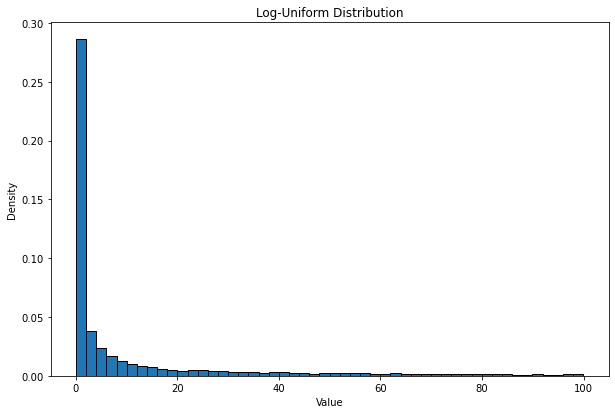

In [20]:
import numpy as np
import matplotlib.pyplot as plt

min_val = 0.01
max_val = 100

# Generate samples from log-uniform distribution
samples = np.exp(np.random.uniform(np.log(min_val), np.log(max_val), 10000))

# Plot histogram
plt.hist(samples, bins=50, density=True, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Log-Uniform Distribution')
plt.show()


In [21]:
#I use log uniform distributions as for the most part smaller values for C and gamma make sense, but we still want 
# to check extremer values

sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'BIC/val',
      'goal': 'maximize'   
    },
    'parameters': {
        'sel__n_features': {
            'distribution': 'int_uniform',
            'min' : 1 ,
            'max' : 20
        },
        'svm__C': {
            'distribution': 'log_uniform_values', 
            'min': 0.01, 
            'max': 50
        },
         'svm__kernel': {
             'values': ['linear', 'rbf', 'poly']
        },
        'svm__gamma': {
             'distribution': 'log_uniform_values', 
                   'min': 0.001, 
                   'max': 1.0
                  }
    }
}

In [22]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
my_entity="hofer1991"
my_project="SVM_Foresthybrid_table"

sweep_id = wandb.sweep(sweep_config, entity=my_entity, project=my_project)

Create sweep with ID: 2qh1wz5t
Sweep URL: https://wandb.ai/hofer1991/SVM_Foresthybrid_table/sweeps/2qh1wz5t


In [23]:
# Training and Evaluation routines for Sweeping

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid**2)
    n = len(y_true)
    bic = num_params * np.log(n) + n * np.log(sse/n)
    return -bic
    

def evaluate_bic(model, X, y, num_params):
    y_pred = model.predict(X) 
    metric  = calculate_bic(y, y_pred, num_params )
    return(metric)
    
def surrogate(C_in, n_features, X, Y):
    linsvc = LinearSVC(C=C_in, max_iter=3000)
    rfe = RFE(estimator=linsvc, n_features_to_select=n_features, step=2)
    rfe.fit(X, Y)    
    return(rfe.support_)



def train(config=None):
    

    
    with wandb.init(config=config):
        
        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config
        
        n_features = config.sel__n_features  # specify the number of desired features
                
        # RFE does not work for general SVC, but it does for Linear SVC
        # here i use linear SVC as a surrogate to find good features, and then log the outputs of the nonlinear SVC 
        # with the selected features 
        
        
        selector_index = surrogate(C_in=config.svm__C,n_features = n_features, X = X_train, Y = y_train)
        
        selected_features = predictors.columns[selector_index]
        selected_features_log = list(selected_features)
        
        
        svc = SVC(C=config.svm__C, gamma = config.svm__gamma, kernel= config.svm__kernel )

        svc.fit(X_train.iloc[:,selector_index], y_train)
        
        bic_train = evaluate_bic(svc, X_train.iloc[:,selector_index], y_train, n_features)
        bic_test  = evaluate_bic(svc, X_test.iloc[:,selector_index] , y_test, n_features)
        
        acc_test  = svc.score(X_test.iloc[:,selector_index], y_test)
        acc_train = svc.score(X_train.iloc[:,selector_index], y_train)
        
        
#         if len(output_container) == 0:
#             output_container = selector_index.tolist()
#         else:
#             output_container = np.vstack([output_container, selector_index.tolist()])
        
        table = wandb.Table(columns = ['GLAD_mean100m', 'GLAD_median100m', 'GLAD_mode100m', 'GLAD_q1',
       'GLAD_q3', 'CLC10m_mean', 'CLC10m_median', 'CLC10m_mode.',
       'CLC10m_q1', 'CLC10m_q3', 'CLC_01.vrt', 'C-GLOPS_mean',
       'C-GLOPS_median', 'C-GLOPS_mode', 'C-GLOPS_q1', 'C-GLOPS_q3',
       'JAXA_q3', 'JAXA_q1', 'JAXA_mode', 'JAXA_median', 'JAXA_mean'] )
        
        table.add_data(selector_index[0],
               selector_index[1],
               selector_index[2],
               selector_index[3],
               selector_index[4],
               selector_index[5],
               selector_index[6],
               selector_index[7],
               selector_index[8],
               selector_index[9],
               selector_index[10],
               selector_index[11],
               selector_index[12],
               selector_index[13],
               selector_index[14],
               selector_index[15],
               selector_index[16],
               selector_index[17],
               selector_index[18],
               selector_index[19],
               selector_index[20])

        
        wandb.log({
               "BIC/train": bic_train,
               "BIC/val": bic_test,
                "Accuracy/train": acc_train,
                "Accuracy/val": acc_test, 
                "table": table
        })
        
        
        # Save the model with the best accuracy
        if bic_test < wandb.run.summary.get("best_accuracy", 0):
            print('bic_test: ',bic_test)
            wandb.run.summary["best_accuracy"] = bic_test
            model_name = "models/best_SVC_Foresthybrid" + str(n_features) + "_featuresel.pkl"
            joblib.dump(svc, model_name)
            

In [24]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: wzu0p4oc with config:
wandb: 	sel__n_features: 9
wandb: 	svm__C: 2.463577051632435
wandb: 	svm__gamma: 0.6710622374468923
wandb: 	svm__kernel: poly


Exception in thread Exception in thread ChkStopThrNetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 257, in check_network_status
    self._loop_check_status(
  File "/home/user/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 213, in _loop_check_status
    local_handle = request()
  File "/home/user/.local/lib/python3.10/site-packages/wandb/sdk/interface/interface.py", line 797, in deliver_network_status
    return self._deliver_network_status(status)
  File "/home/user/.local/lib/python3.10/site-packages/wandb/sdk/interface/interface_shared.py", line 601, in _deliver_network_status
    return self._deliver_record(record)
  File "/home/user/.local/lib/python3.10/site-packages/wandb/sdk/interface/i

Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.89936
BIC/train,26028.0644
BIC/val,24967.75006


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fk3jg4j0 with config:
wandb: 	sel__n_features: 3
wandb: 	svm__C: 0.18761546519173297
wandb: 	svm__gamma: 0.3524629045434269
wandb: 	svm__kernel: poly
wandb: Currently logged in as: hofer1991. Use `wandb login --relogin` to force relogin


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90027
Accuracy/val,0.89358
BIC/train,25120.04736
BIC/val,24414.85093


wandb: Agent Starting Run: qtgeuw5a with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 2.2773592335006976
wandb: 	svm__gamma: 0.00275506193970229
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90073
BIC/train,25954.84266
BIC/val,25099.22633


wandb: Agent Starting Run: techw998 with config:
wandb: 	sel__n_features: 9
wandb: 	svm__C: 0.219853630835546
wandb: 	svm__gamma: 0.26687900849357427
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90366
Accuracy/val,0.89597
BIC/train,25441.70441
BIC/val,24606.16748


wandb: Agent Starting Run: lpdecdsc with config:
wandb: 	sel__n_features: 6
wandb: 	svm__C: 0.016271087916469626
wandb: 	svm__gamma: 0.1354509548676081
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90668
Accuracy/val,0.89844
BIC/train,25817.61725
BIC/val,24896.72963


wandb: Agent Starting Run: oyctysgv with config:
wandb: 	sel__n_features: 5
wandb: 	svm__C: 0.012076055801335611
wandb: 	svm__gamma: 0.7809753457161314
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90522
Accuracy/val,0.89716
BIC/train,25656.79029
BIC/val,24769.03872


wandb: Agent Starting Run: s4k7ztes with config:
wandb: 	sel__n_features: 18
wandb: 	svm__C: 2.0563031759799664
wandb: 	svm__gamma: 0.13069509669446433
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90897
Accuracy/val,0.9
BIC/train,25977.29633
BIC/val,24953.84953


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dqjmy50b with config:
wandb: 	sel__n_features: 15
wandb: 	svm__C: 0.02763864705673385
wandb: 	svm__gamma: 0.0024507784822863084
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90311
Accuracy/val,0.89679
BIC/train,25323.81961
BIC/val,24637.2387


wandb: Agent Starting Run: 2ngtlmhu with config:
wandb: 	sel__n_features: 3
wandb: 	svm__C: 0.163752591736635
wandb: 	svm__gamma: 0.33548454243030906
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90292
Accuracy/val,0.89551
BIC/train,25414.7658
BIC/val,24613.99597


wandb: Agent Starting Run: jlg4ohge with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 1.2047400891333324
wandb: 	svm__gamma: 0.00436100076708698
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90292
Accuracy/val,0.89523
BIC/train,25349.6844
BIC/val,24520.24111


wandb: Agent Starting Run: blwas5d8 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.9230148433677304
wandb: 	svm__gamma: 0.0017243671019036308
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90173
Accuracy/val,0.8956
BIC/train,25197.98904
BIC/val,24539.89343


wandb: Agent Starting Run: cq83qedy with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 3.0370872420903656
wandb: 	svm__gamma: 0.0020656950164319775
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90073
BIC/train,25965.7462
BIC/val,25099.22633


wandb: Agent Starting Run: xxd37y15 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 2.6720961497807427
wandb: 	svm__gamma: 0.002479707923372288
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90073
BIC/train,25985.95801
BIC/val,25108.52376


wandb: Agent Starting Run: fjjr4qcz with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 4.059712614359525
wandb: 	svm__gamma: 0.0015107429425709972
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90861
Accuracy/val,0.90064
BIC/train,25998.52239
BIC/val,25089.15711


wandb: Agent Starting Run: 691kfqe6 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 8.833286939956599
wandb: 	svm__gamma: 0.004642299108896271
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90064
BIC/train,25975.04355
BIC/val,25098.45454


wandb: Agent Starting Run: 102usy7t with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 4.44573128747292
wandb: 	svm__gamma: 0.00167522553235588
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90073
BIC/train,25985.95801
BIC/val,25108.52376


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0zqkgboa with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 6.213258582072139
wandb: 	svm__gamma: 0.003607896929088766
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90852
Accuracy/val,0.90064
BIC/train,25987.58605
BIC/val,25089.15711


wandb: Agent Starting Run: 6yez8klz with config:
wandb: 	sel__n_features: 8
wandb: 	svm__C: 2.4702073661436033
wandb: 	svm__gamma: 0.003157932579375454
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90742
Accuracy/val,0.89963
BIC/train,25885.09008
BIC/val,25006.89703


wandb: Agent Starting Run: hplatulu with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 10.823655588519465
wandb: 	svm__gamma: 0.0014806652124461834
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90064
BIC/train,25975.04355
BIC/val,25098.45454


wandb: Agent Starting Run: usolnoul with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 4.213305831756995
wandb: 	svm__gamma: 0.002448799794492624
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90064
BIC/train,25985.95801
BIC/val,25098.45454


wandb: Agent Starting Run: oogp32g2 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 27.539226342454366
wandb: 	svm__gamma: 0.0047316945913837526
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90064
BIC/train,25954.84266
BIC/val,25089.15711


wandb: Agent Starting Run: ilj3zd4k with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.615840710156643
wandb: 	svm__gamma: 0.0030255523349574293
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90852
Accuracy/val,0.90073
BIC/train,25987.58605
BIC/val,25099.22633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5f7yvfyl with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 7.288255249465661
wandb: 	svm__gamma: 0.0039942697772720505
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.90046
BIC/train,26022.10001
BIC/val,25059.74907


wandb: Agent Starting Run: alg8zuy6 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 7.23732605400855
wandb: 	svm__gamma: 0.0018082977211440097
wandb: 	svm__kernel: linear


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90064
BIC/train,25985.95801
BIC/val,25098.45454


wandb: Agent Starting Run: p8sz7c46 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.1185042530624858
wandb: 	svm__gamma: 0.0013026754670844628
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.90101
BIC/train,26012.80267
BIC/val,25110.895


wandb: Agent Starting Run: f5x2p1gk with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.7395248776344175
wandb: 	svm__gamma: 0.0017147648843011184
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90119
BIC/train,25943.94999
BIC/val,25149.71231


wandb: Agent Starting Run: vbd3s57w with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7832592023405508
wandb: 	svm__gamma: 0.001559033273342185
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90119
BIC/train,25934.65265
BIC/val,25140.41487


wandb: Agent Starting Run: e7fx8sqf with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.3284720179085004
wandb: 	svm__gamma: 0.002550645326406897
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25891.19044
BIC/val,25160.67486


wandb: Agent Starting Run: vcfnymjc with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.3686000546305761
wandb: 	svm__gamma: 0.0021055231620187563
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90147
BIC/train,25958.06598
BIC/val,25161.52154


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w8q5zcvo with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.14866110967766497
wandb: 	svm__gamma: 0.003035037699098467
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90622
Accuracy/val,0.90009
BIC/train,25699.08645
BIC/val,25010.34129


wandb: Agent Starting Run: apphm3q4 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.3738720192846415
wandb: 	svm__gamma: 0.0013976477237537636
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25869.5241
BIC/val,25150.54016


wandb: Agent Starting Run: lhh48vqy with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.4605997256310479
wandb: 	svm__gamma: 0.002395628883167499
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90147
BIC/train,25900.48778
BIC/val,25180.11641


wandb: Agent Starting Run: z1qg5kwd with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.075113481366823
wandb: 	svm__gamma: 0.0012001930376657024
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.90101
BIC/train,26012.80267
BIC/val,25110.895


wandb: Agent Starting Run: 0gffyrrw with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 2.383903166561636
wandb: 	svm__gamma: 0.001686140100984577
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90907
Accuracy/val,0.90082
BIC/train,26034.77448
BIC/val,25090.70998


wandb: Agent Starting Run: g5c6ku8l with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.0240636703862498
wandb: 	svm__gamma: 0.0015593596528254163
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90092
BIC/train,25965.7462
BIC/val,25119.39269


wandb: Agent Starting Run: xs48jodx with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.5786826334919054
wandb: 	svm__gamma: 0.0013530284303998545
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.9011
BIC/train,26012.80267
BIC/val,25121.00153


wandb: Agent Starting Run: qwfb8dci with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.0427626536555572
wandb: 	svm__gamma: 0.001200990542846809
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.90064
BIC/train,26000.17237
BIC/val,25079.85967


wandb: Agent Starting Run: sc5xj1h2 with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 1.6705430796837364
wandb: 	svm__gamma: 0.0022606204082976224
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9065
Accuracy/val,0.90009
BIC/train,25721.82731
BIC/val,25001.04386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w6dxtxti with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.7460077608505465
wandb: 	svm__gamma: 0.0019988938572013527
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90897
Accuracy/val,0.9011
BIC/train,26023.78304
BIC/val,25121.00153


wandb: Agent Starting Run: 7d5xnajt with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.42721223251138907
wandb: 	svm__gamma: 0.001927270618623437
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90751
Accuracy/val,0.90137
BIC/train,25858.70704
BIC/val,25160.67486


wandb: Agent Starting Run: fpgqe825 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.073833084825936
wandb: 	svm__gamma: 0.002206505437710533
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.90064
BIC/train,26000.17237
BIC/val,25079.85967


wandb: Agent Starting Run: 7s9h9gbc with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.6085243633361147
wandb: 	svm__gamma: 0.002492244597041028
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90128
BIC/train,25909.78513
BIC/val,25169.13503


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0nn54ufi with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 2.457541250558839
wandb: 	svm__gamma: 0.002183036458532818
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90055
BIC/train,26011.13068
BIC/val,25069.79974


wandb: Agent Starting Run: 0u3yx0ei with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.3922282927703909
wandb: 	svm__gamma: 0.0014985534018379276
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25869.5241
BIC/val,25150.54016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: us0sq78m with config:
wandb: 	sel__n_features: 9
wandb: 	svm__C: 0.5254967437332946
wandb: 	svm__gamma: 0.001568227554358359
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9065
Accuracy/val,0.90027
BIC/train,25768.31403
BIC/val,25067.56777


wandb: Agent Starting Run: dzw2qokf with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.34342526523091965
wandb: 	svm__gamma: 0.0017711377582156898
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25891.19044
BIC/val,25160.67486


wandb: Agent Starting Run: j6a9zyal with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.7904802206868866
wandb: 	svm__gamma: 0.0025424543247662182
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90101
BIC/train,25911.33711
BIC/val,25129.48987


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9usb3cvr with config:
wandb: 	sel__n_features: 8
wandb: 	svm__C: 0.4385153255328807
wandb: 	svm__gamma: 0.002827827284302027
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90632
Accuracy/val,0.90018
BIC/train,25756.24212
BIC/val,25066.84224


wandb: Agent Starting Run: j3zlak17 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.8013996723022563
wandb: 	svm__gamma: 0.003963564744349219
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90092
BIC/train,25942.36554
BIC/val,25128.69013


wandb: Agent Starting Run: 0ms5jvc2 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.718799143913217
wandb: 	svm__gamma: 0.0016882824991327331
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90119
BIC/train,25922.19724
BIC/val,25149.71231


wandb: Agent Starting Run: vh1pd7xb with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4520271764622179
wandb: 	svm__gamma: 0.002833740655710864
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25891.19044
BIC/val,25160.67486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 830e6wwf with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.590073262281755
wandb: 	svm__gamma: 0.0030845855903035555
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90128
BIC/train,25891.19044
BIC/val,25150.54016


wandb: Agent Starting Run: aqh7xpfs with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.28021254067897433
wandb: 	svm__gamma: 0.002754941519641726
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90101
BIC/train,25909.78513
BIC/val,25138.78731


wandb: Agent Starting Run: rthy8urd with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.003932244678195
wandb: 	svm__gamma: 0.0016462799387547205
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.90064
BIC/train,26000.17237
BIC/val,25079.85967


wandb: Agent Starting Run: fwnokwoy with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.655549029044595
wandb: 	svm__gamma: 0.001016572441451141
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90897
Accuracy/val,0.90092
BIC/train,26023.78304
BIC/val,25100.79782


wandb: Agent Starting Run: orjt09l0 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.8687790819706643
wandb: 	svm__gamma: 0.0018301741643930289
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90073
BIC/train,25976.66066
BIC/val,25099.22633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4wp31it with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4652000565222423
wandb: 	svm__gamma: 0.0030963872451269347
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25880.35189
BIC/val,25160.67486


wandb: Agent Starting Run: 12wlyl41 with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.3871976549717993
wandb: 	svm__gamma: 0.0012335867979547013
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90577
Accuracy/val,0.90055
BIC/train,25636.60032
BIC/val,25051.20487


wandb: Agent Starting Run: 0gkdbchg with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.9258953474647946
wandb: 	svm__gamma: 0.002364701800274635
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90861
Accuracy/val,0.90092
BIC/train,25979.92771
BIC/val,25100.79782


wandb: Agent Starting Run: gdj0q7uo with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.7441680372665628
wandb: 	svm__gamma: 0.0014565487731562107
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.90119
BIC/train,26012.80267
BIC/val,25131.11744


wandb: Agent Starting Run: ibz0bqpz with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.9329351304154212
wandb: 	svm__gamma: 0.002993737643738404
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90092
BIC/train,25954.84266
BIC/val,25119.39269


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uj0adl4p with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.9464775122238908
wandb: 	svm__gamma: 0.001804925794990131
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90092
BIC/train,25954.84266
BIC/val,25119.39269


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8b5l2i1a with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.0595462684469208
wandb: 	svm__gamma: 0.005042945908872903
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.90064
BIC/train,26000.17237
BIC/val,25079.85967


wandb: Agent Starting Run: 4oedj56u with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.25871657705806383
wandb: 	svm__gamma: 0.0029643583232603636
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90119
BIC/train,25954.84266
BIC/val,25149.71231


wandb: Agent Starting Run: 77xcu35t with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.6058025446292057
wandb: 	svm__gamma: 0.002365650132716511
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25889.64923
BIC/val,25169.97229


wandb: Agent Starting Run: 4o6rmtsy with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7846728583627861
wandb: 	svm__gamma: 0.002258124900156887
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90119
BIC/train,25912.8999
BIC/val,25140.41487


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5v8b2bxi with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.8892856851303369
wandb: 	svm__gamma: 0.003935408343545644
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90082
BIC/train,25965.7462
BIC/val,25109.30485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vw37tau0 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.48761853026226
wandb: 	svm__gamma: 0.003838664058899694
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90101
BIC/train,25909.78513
BIC/val,25138.78731


wandb: Agent Starting Run: l6mw9e73 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.5826741915982985
wandb: 	svm__gamma: 0.002648303920417899
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.9011
BIC/train,26012.80267
BIC/val,25121.00153


wandb: Agent Starting Run: 7qke4ay6 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 1.094616241310904
wandb: 	svm__gamma: 0.002903235834089206
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90082
BIC/train,25953.24734
BIC/val,25118.60229


wandb: Agent Starting Run: qy4xf1xu with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.3138802339858064
wandb: 	svm__gamma: 0.0013544935222142523
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90852
Accuracy/val,0.90055
BIC/train,25978.28871
BIC/val,25069.79974


wandb: Agent Starting Run: 56za54o6 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4993723353795888
wandb: 	svm__gamma: 0.0024906415552237676
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25880.35189
BIC/val,25160.67486


wandb: Agent Starting Run: 43rky15z with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.28868478624009597
wandb: 	svm__gamma: 0.001127185177565002
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90119
BIC/train,25933.0682
BIC/val,25149.71231


wandb: Agent Starting Run: l3uwpzv9 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 1.4140465083953773
wandb: 	svm__gamma: 0.002922210936114063
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90861
Accuracy/val,0.90073
BIC/train,26007.81974
BIC/val,25108.52376


wandb: Agent Starting Run: rywykv42 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.2790946294975214
wandb: 	svm__gamma: 0.0016517204395573243
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90128
BIC/train,25891.19044
BIC/val,25150.54016


wandb: Agent Starting Run: k1u3f067 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.7511886424698048
wandb: 	svm__gamma: 0.0027110484740073743
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90101
BIC/train,25943.94999
BIC/val,25129.48987


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0kec4e6x with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.050690888342657
wandb: 	svm__gamma: 0.001578899930087819
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90092
BIC/train,25965.7462
BIC/val,25119.39269


wandb: Agent Starting Run: 3x1si710 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5352687788508452
wandb: 	svm__gamma: 0.002443545024872077
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25880.35189
BIC/val,25160.67486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6iptn4y0 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.564507997511205
wandb: 	svm__gamma: 0.003664769749223907
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25889.64923
BIC/val,25169.97229


wandb: Agent Starting Run: z03autm9 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.3415522908635564
wandb: 	svm__gamma: 0.0013484557322767708
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90082
BIC/train,25976.66066
BIC/val,25109.30485


wandb: Agent Starting Run: rftnpnrh with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.5628074030737188
wandb: 	svm__gamma: 0.005003664050873561
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25889.64923
BIC/val,25169.97229


wandb: Agent Starting Run: udaafx7b with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.5947028800401202
wandb: 	svm__gamma: 0.0017452800170073373
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90119
BIC/train,25909.78513
BIC/val,25159.00974


wandb: Agent Starting Run: jf0khnoe with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.8451967650375967
wandb: 	svm__gamma: 0.0011966516638102572
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90092
BIC/train,26001.83334
BIC/val,25100.79782


wandb: Agent Starting Run: ay3ga8ev with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.5452899413129354
wandb: 	svm__gamma: 0.002962564220190038
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.9011
BIC/train,25990.87502
BIC/val,25121.00153


wandb: Agent Starting Run: l3wuu7hr with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.1821874703452626
wandb: 	svm__gamma: 0.004195118799852474
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90092
BIC/train,25954.84266
BIC/val,25119.39269


wandb: Agent Starting Run: fhlejm6z with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.5209952897323172
wandb: 	svm__gamma: 0.0010701163552269172
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90861
Accuracy/val,0.90119
BIC/train,25979.92771
BIC/val,25131.11744


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ghuyaqcs with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.45642177165453407
wandb: 	svm__gamma: 0.001996289767530718
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90861
Accuracy/val,0.90128
BIC/train,25979.92771
BIC/val,25141.24273


wandb: Agent Starting Run: qmzxoch0 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 2.755100354351284
wandb: 	svm__gamma: 0.0012560257608762102
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90064
BIC/train,25965.7462
BIC/val,25089.15711


wandb: Agent Starting Run: 02tzay9d with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.4028313023045982
wandb: 	svm__gamma: 0.002501394170816838
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90064
BIC/train,26011.13068
BIC/val,25079.85967


wandb: Agent Starting Run: yd0wse5w with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7235999673303372
wandb: 	svm__gamma: 0.015964020938238958
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90137
BIC/train,25902.03977
BIC/val,25160.67486


wandb: Agent Starting Run: qbvtqilg with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.8842444355651944
wandb: 	svm__gamma: 0.018561189658921097
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90082
BIC/train,25953.24734
BIC/val,25118.60229


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1cptyci2 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.6109400897011511
wandb: 	svm__gamma: 0.0013475762106660166
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90888
Accuracy/val,0.90101
BIC/train,26012.80267
BIC/val,25110.895


wandb: Agent Starting Run: zv4k0wsk with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4182952618588043
wandb: 	svm__gamma: 0.002493390991209447
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90751
Accuracy/val,0.90137
BIC/train,25858.70704
BIC/val,25160.67486


wandb: Agent Starting Run: 9rz66109 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.3135305765726975
wandb: 	svm__gamma: 0.007240299613342285
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90082
BIC/train,25920.63446
BIC/val,25118.60229


wandb: Agent Starting Run: bvmu2e5l with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.8189935858809309
wandb: 	svm__gamma: 0.004033162324375906
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90082
BIC/train,25922.19724
BIC/val,25109.30485


wandb: Agent Starting Run: 5rhp7dtt with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5527048415182402
wandb: 	svm__gamma: 0.0035684163881414314
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90128
BIC/train,25891.19044
BIC/val,25150.54016


wandb: Agent Starting Run: d91dk1ef with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.226086516074399
wandb: 	svm__gamma: 0.00392332828116328
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90101
BIC/train,26001.83334
BIC/val,25110.895


wandb: Agent Starting Run: lrbi77l4 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.1216132522691202
wandb: 	svm__gamma: 0.0022338269744789797
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90055
BIC/train,26011.13068
BIC/val,25069.79974


wandb: Agent Starting Run: wl7sliy0 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5914457963431596
wandb: 	svm__gamma: 0.0017996928662319925
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90128
BIC/train,25891.19044
BIC/val,25150.54016


wandb: Agent Starting Run: sy52rsk7 with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.33749127512370664
wandb: 	svm__gamma: 0.012322716094151774
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90586
Accuracy/val,0.90064
BIC/train,25647.21735
BIC/val,25061.2648


wandb: Agent Starting Run: z5bjryra with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.8425184399481425
wandb: 	svm__gamma: 0.011575949734092397
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90092
BIC/train,25902.03977
BIC/val,25110.09526


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xpvdyyo6 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.3007436718101246
wandb: 	svm__gamma: 0.004991413786357445
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90119
BIC/train,25922.19724
BIC/val,25149.71231


wandb: Agent Starting Run: uscc5ndh with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.8495140205015046
wandb: 	svm__gamma: 0.005044828120087547
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90082
BIC/train,25912.8999
BIC/val,25100.00742


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e96k6c2u with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.3292497557140546
wandb: 	svm__gamma: 0.0032332916450934115
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90852
Accuracy/val,0.90082
BIC/train,25987.58605
BIC/val,25109.30485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egopjz3e with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.3105544687224219
wandb: 	svm__gamma: 0.006208177560741168
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90147
BIC/train,25891.19044
BIC/val,25170.81898


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7wmnaosu with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.40140989586670023
wandb: 	svm__gamma: 0.0016947538203568257
wandb: 	svm__kernel: linear
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90119
BIC/train,25958.06598
BIC/val,25131.11744


wandb: Agent Starting Run: qrjcwbx7 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 1.1290536174010206
wandb: 	svm__gamma: 0.010196206467248592
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90879
Accuracy/val,0.90055
BIC/train,26011.13068
BIC/val,25069.79974


wandb: Agent Starting Run: 06iz97yo with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.6120027449380949
wandb: 	svm__gamma: 0.002147046541745919
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25889.64923
BIC/val,25169.97229


wandb: Agent Starting Run: p8ijij0n with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4021112866926896
wandb: 	svm__gamma: 0.0020552072853446545
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25869.5241
BIC/val,25150.54016


wandb: Agent Starting Run: 7io4l7n6 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.5072891968100036
wandb: 	svm__gamma: 0.007497565639185451
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90101
BIC/train,25909.78513
BIC/val,25138.78731


wandb: Agent Starting Run: 8qzmhr1j with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.5559384006942809
wandb: 	svm__gamma: 0.002437108705977061
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90119
BIC/train,25878.82144
BIC/val,25149.71231


wandb: Agent Starting Run: wamqs14r with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.4738825249570026
wandb: 	svm__gamma: 0.03412156265188652
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90558
Accuracy/val,0.90046
BIC/train,25615.3972
BIC/val,25041.1542


wandb: Agent Starting Run: l37whypg with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4072123192430412
wandb: 	svm__gamma: 0.006146548384425544
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90137
BIC/train,25869.5241
BIC/val,25160.67486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o53vtbd3 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.6321494812409584
wandb: 	svm__gamma: 0.0017083695686582075
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90897
Accuracy/val,0.90092
BIC/train,26023.78304
BIC/val,25100.79782


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vm1pwnb3 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.5359031240146457
wandb: 	svm__gamma: 0.0016498698041404465
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25878.82144
BIC/val,25159.8376


wandb: Agent Starting Run: poz2kfg3 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.765880775444973
wandb: 	svm__gamma: 0.005186063837022537
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.9011
BIC/train,25911.33711
BIC/val,25139.5964


wandb: Agent Starting Run: 9o6b54wa with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.8883191223944908
wandb: 	svm__gamma: 0.0022275583592324196
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90082
BIC/train,25943.94999
BIC/val,25109.30485


wandb: Agent Starting Run: wu0a6jcg with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7693934315218106
wandb: 	svm__gamma: 0.002385650468366885
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90128
BIC/train,25912.8999
BIC/val,25150.54016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0pt66vrq with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.45730779601565064
wandb: 	svm__gamma: 0.0024935841918376916
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.9011
BIC/train,25909.78513
BIC/val,25148.89384


wandb: Agent Starting Run: ctvl29hb with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.18142933927498137
wandb: 	svm__gamma: 0.001889363305419218
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90137
BIC/train,25964.14
BIC/val,25179.26973


wandb: Agent Starting Run: 8qhhaok1 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.26562349720533773
wandb: 	svm__gamma: 0.0018383599538977164
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90119
BIC/train,25954.84266
BIC/val,25149.71231


wandb: Agent Starting Run: n7gzuc0t with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.532952384652711
wandb: 	svm__gamma: 0.013297146331173956
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90119
BIC/train,25909.78513
BIC/val,25159.00974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 39a8t6bn with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.10786238956425316
wandb: 	svm__gamma: 0.0019276937295922827
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90046
BIC/train,25975.04355
BIC/val,25078.34394


wandb: Agent Starting Run: enfxjfx6 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4263404218865864
wandb: 	svm__gamma: 0.0029664747229420215
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90751
Accuracy/val,0.90137
BIC/train,25858.70704
BIC/val,25160.67486


wandb: Agent Starting Run: 7c2emgp0 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4415627982428685
wandb: 	svm__gamma: 0.001756773899494451
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25891.19044
BIC/val,25160.67486


wandb: Agent Starting Run: uvirkh5l with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5239321653641408
wandb: 	svm__gamma: 0.0027456701200057865
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25880.35189
BIC/val,25160.67486


wandb: Agent Starting Run: 5cv4yocj with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4590665589327533
wandb: 	svm__gamma: 0.008577735211846755
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25891.19044
BIC/val,25160.67486


wandb: Agent Starting Run: 0ie6q84b with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.42955095372542784
wandb: 	svm__gamma: 0.0017375517459842678
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90852
Accuracy/val,0.90128
BIC/train,25968.99137
BIC/val,25141.24273


wandb: Agent Starting Run: 8uwkchov with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.3695462918366476
wandb: 	svm__gamma: 0.004817515681623445
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90137
BIC/train,25922.19724
BIC/val,25169.97229


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8opk6yta with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.5351236298504858
wandb: 	svm__gamma: 0.005133948621202614
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.9011
BIC/train,25990.87502
BIC/val,25121.00153


wandb: Agent Starting Run: ao6kgy0g with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.06869685668341935
wandb: 	svm__gamma: 0.001916662508190057
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90018
BIC/train,25942.36554
BIC/val,25048.24737


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: up4lsdhl with config:
wandb: 	sel__n_features: 8
wandb: 	svm__C: 0.3747310874295304
wandb: 	svm__gamma: 0.0017650158449582791
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90622
Accuracy/val,0.90046
BIC/train,25745.57317
BIC/val,25096.93881


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4977un5 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.6823492400781629
wandb: 	svm__gamma: 0.0029381591848574315
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90128
BIC/train,25911.33711
BIC/val,25159.8376


wandb: Agent Starting Run: eq7eekhl with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.9462243931395116
wandb: 	svm__gamma: 0.003469707700612451
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90092
BIC/train,25923.77085
BIC/val,25110.09526


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2264fhp with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.33735767674439443
wandb: 	svm__gamma: 0.001388826911740006
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90156
BIC/train,25947.15152
BIC/val,25171.6751


wandb: Agent Starting Run: peebkduy with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.2579849672881198
wandb: 	svm__gamma: 0.02065637399475609
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90156
BIC/train,25914.47351
BIC/val,25171.6751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ns5xwkjv with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.4160783873772027
wandb: 	svm__gamma: 0.012702515454164828
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90751
Accuracy/val,0.90137
BIC/train,25858.70704
BIC/val,25160.67486


wandb: Agent Starting Run: d54mfe1m with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.22586038038789283
wandb: 	svm__gamma: 0.02117442376312342
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90439
Accuracy/val,0.89679
BIC/train,25487.86979
BIC/val,24655.83357


wandb: Agent Starting Run: 2jj4783c with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.3925169279223528
wandb: 	svm__gamma: 0.008025949401416465
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25869.5241
BIC/val,25150.54016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hks5qefr with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.5305958944574876
wandb: 	svm__gamma: 0.016123150017765528
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.9011
BIC/train,25909.78513
BIC/val,25148.89384


wandb: Agent Starting Run: ywu66kic with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.42566354011215823
wandb: 	svm__gamma: 0.01056770098585635
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90751
Accuracy/val,0.90137
BIC/train,25858.70704
BIC/val,25160.67486


wandb: Agent Starting Run: pqoj6h43 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7149598508108476
wandb: 	svm__gamma: 0.005621359449853696
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90128
BIC/train,25912.8999
BIC/val,25150.54016


wandb: Agent Starting Run: 1wxnlcri with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.2110739933990342
wandb: 	svm__gamma: 0.018497239793176728
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90824
Accuracy/val,0.90156
BIC/train,25945.54531
BIC/val,25180.97254


wandb: Agent Starting Run: x4ilc4qw with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.6233815741995599
wandb: 	svm__gamma: 0.0033265226765701434
wandb: 	svm__kernel: poly


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.67916
Accuracy/val,0.67571
BIC/train,12290.05764
BIC/val,12174.38039


wandb: Agent Starting Run: o7jfg3h8 with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.2800505297486016
wandb: 	svm__gamma: 0.03376450927593468
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90604
Accuracy/val,0.90064
BIC/train,25668.48246
BIC/val,25061.2648


wandb: Agent Starting Run: mm3rrq4m with config:
wandb: 	sel__n_features: 17
wandb: 	svm__C: 0.012511888858069016
wandb: 	svm__gamma: 0.017845712050839707
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90237
Accuracy/val,0.89679
BIC/train,25222.97006
BIC/val,24618.64383


wandb: Agent Starting Run: d0bhbpll with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 1.01802426393402
wandb: 	svm__gamma: 0.0029483526407196228
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90632
Accuracy/val,0.90009
BIC/train,25700.45806
BIC/val,25001.04386


wandb: Agent Starting Run: y4j5jtk9 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.1998729658279343
wandb: 	svm__gamma: 0.014135438305853811
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90192
BIC/train,25925.35531
BIC/val,25212.38411


wandb: Agent Starting Run: ijwos5bw with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.9967688423136442
wandb: 	svm__gamma: 0.002580898125512621
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90302
Accuracy/val,0.8967
BIC/train,25322.80112
BIC/val,24636.85127


wandb: Agent Starting Run: 7rxnt8tr with config:
wandb: 	sel__n_features: 17
wandb: 	svm__C: 1.6216855856587746
wandb: 	svm__gamma: 0.0012344971246623117
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9032
Accuracy/val,0.8978
BIC/train,25315.55053
BIC/val,24725.74866


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jl8l1km9 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.7807683945125635
wandb: 	svm__gamma: 0.004080568263851484
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90283
Accuracy/val,0.89624
BIC/train,25311.496
BIC/val,24597.85292


wandb: Agent Starting Run: eviakw4b with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.3203635483183435
wandb: 	svm__gamma: 0.0027902826877387564
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90156
BIC/train,25947.15152
BIC/val,25171.6751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qjtkzqjk with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.13109017582756902
wandb: 	svm__gamma: 0.02864600234696627
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90137
BIC/train,25912.8999
BIC/val,25160.67486


wandb: Agent Starting Run: a3p847qu with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.8725853526284182
wandb: 	svm__gamma: 0.0049216744191044794
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9032
Accuracy/val,0.89734
BIC/train,25343.44256
BIC/val,24704.82657


wandb: Agent Starting Run: qadws03k with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.7756582973176728
wandb: 	svm__gamma: 0.0013900131757641947
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90265
Accuracy/val,0.89514
BIC/train,25281.63503
BIC/val,24473.51048


wandb: Agent Starting Run: l7i0ap0k with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.5635192108140243
wandb: 	svm__gamma: 0.006100995670347247
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25889.64923
BIC/val,25169.97229


wandb: Agent Starting Run: 5iez1wfh with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7872147836911865
wandb: 	svm__gamma: 0.006141547121476231
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90292
Accuracy/val,0.89633
BIC/train,25331.08971
BIC/val,24616.79242


wandb: Agent Starting Run: rqwe4kb4 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.39257275825800825
wandb: 	svm__gamma: 0.00940373144059064
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90147
BIC/train,25922.19724
BIC/val,25180.11641


wandb: Agent Starting Run: qdab4j63 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 2.272365476848044
wandb: 	svm__gamma: 0.00628039574596607
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90613
Accuracy/val,0.89918
BIC/train,25697.72527
BIC/val,24920.00333


wandb: Agent Starting Run: 1nbrq9fy with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.4290157582250813
wandb: 	svm__gamma: 0.004820315548862619
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90219
Accuracy/val,0.89606
BIC/train,25239.69226
BIC/val,24578.59431


wandb: Agent Starting Run: 6o6kinpj with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.31349506763448115
wandb: 	svm__gamma: 0.009476811484058555
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90119
BIC/train,25911.33711
BIC/val,25149.71231


wandb: Agent Starting Run: ydwirv36 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.19336940180241147
wandb: 	svm__gamma: 0.017852206394585117
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90156
BIC/train,25934.65265
BIC/val,25180.97254


wandb: Agent Starting Run: es7z5dpu with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.6085114044556783
wandb: 	svm__gamma: 0.001425526338690723
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90109
Accuracy/val,0.89514
BIC/train,25136.28381
BIC/val,24501.40279


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ugyvhmwd with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.4634504616524217
wandb: 	svm__gamma: 0.003177016771819509
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9087
Accuracy/val,0.90128
BIC/train,25990.87502
BIC/val,25141.24273


wandb: Agent Starting Run: 61fpw6kx with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.46988082811401577
wandb: 	svm__gamma: 0.009798050240412987
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90778
Accuracy/val,0.90137
BIC/train,25900.48778
BIC/val,25169.97229


wandb: Agent Starting Run: gaoteujw with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.6112211761769599
wandb: 	svm__gamma: 0.0028228749090149084
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90219
Accuracy/val,0.89597
BIC/train,25239.69226
BIC/val,24568.97774


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnaag464 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.8107707418458368
wandb: 	svm__gamma: 0.00699594392447351
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90347
Accuracy/val,0.89716
BIC/train,25383.77549
BIC/val,24694.65923


wandb: Agent Starting Run: hsh0q5f3 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.40190931443619154
wandb: 	svm__gamma: 0.004524208697885525
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9076
Accuracy/val,0.90128
BIC/train,25869.5241
BIC/val,25150.54016


wandb: Agent Starting Run: 5cwh2bv1 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.2901642686919752
wandb: 	svm__gamma: 0.01351255583653167
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90119
BIC/train,25912.8999
BIC/val,25140.41487


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ho2lefm with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.8628268439364988
wandb: 	svm__gamma: 0.0020909111721198487
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90897
Accuracy/val,0.90092
BIC/train,26023.78304
BIC/val,25100.79782


wandb: Agent Starting Run: 6o5dsd7v with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 2.037097631423543
wandb: 	svm__gamma: 0.003618941347161008
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90457
Accuracy/val,0.89771
BIC/train,25508.80837
BIC/val,24753.15803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zq15dx1j with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.923773394876146
wandb: 	svm__gamma: 0.007846045095072064
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90494
Accuracy/val,0.89762
BIC/train,25550.8065
BIC/val,24743.38643


wandb: Agent Starting Run: 7uxheq3j with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5139279170581069
wandb: 	svm__gamma: 0.00127889398137261
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90128
BIC/train,25880.35189
BIC/val,25150.54016


wandb: Agent Starting Run: v27ewant with config:
wandb: 	sel__n_features: 15
wandb: 	svm__C: 2.946629937159473
wandb: 	svm__gamma: 0.004605752672185497
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90531
Accuracy/val,0.89863
BIC/train,25574.37225
BIC/val,24832.76365


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqsmuxnm with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.1033201966570183
wandb: 	svm__gamma: 0.010080496695403262
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90549
Accuracy/val,0.89881
BIC/train,25614.10842
BIC/val,24871.10513


wandb: Agent Starting Run: bfn48c63 with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 2.149160907114762
wandb: 	svm__gamma: 0.004906828258489779
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90503
Accuracy/val,0.89826
BIC/train,25570.62869
BIC/val,24821.26963


wandb: Agent Starting Run: 7n1yxgmv with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.5208875554349679
wandb: 	svm__gamma: 0.0032369147543362033
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90769
Accuracy/val,0.90137
BIC/train,25880.35189
BIC/val,25160.67486


wandb: Agent Starting Run: qiumxm1g with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.33571410709916233
wandb: 	svm__gamma: 0.016629715129913
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90119
BIC/train,25911.33711
BIC/val,25149.71231


wandb: Agent Starting Run: 3tong0rs with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.6600832393895582
wandb: 	svm__gamma: 0.00457853003596939
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90512
Accuracy/val,0.89771
BIC/train,25571.86635
BIC/val,24753.15803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cis6ihk5 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.09535374760048156
wandb: 	svm__gamma: 0.027027753091686865
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90797
Accuracy/val,0.90037
BIC/train,25922.19724
BIC/val,25059.00509


wandb: Agent Starting Run: 06yfali9 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.4221147468177557
wandb: 	svm__gamma: 0.023771366880279657
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90147
BIC/train,25911.33711
BIC/val,25180.11641


wandb: Agent Starting Run: 6aamiykx with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.3229857171153838
wandb: 	svm__gamma: 0.005970536585121469
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90329
Accuracy/val,0.89688
BIC/train,25381.66998
BIC/val,24684.12191


wandb: Agent Starting Run: c92jt78l with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.2036284216982213
wandb: 	svm__gamma: 0.004093963128926062
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.9021
Accuracy/val,0.89578
BIC/train,25229.47306
BIC/val,24549.76999


wandb: Agent Starting Run: les8krbd with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 2.059845232853824
wandb: 	svm__gamma: 0.0030344745813087126
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90412
Accuracy/val,0.89826
BIC/train,25447.23973
BIC/val,24802.67476


wandb: Agent Starting Run: 9rm84e7u with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.7653502208709801
wandb: 	svm__gamma: 0.002833106834338693
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90201
Accuracy/val,0.89588
BIC/train,25228.56076
BIC/val,24568.66707


wandb: Agent Starting Run: w70ce5pj with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.8447206708436912
wandb: 	svm__gamma: 0.004624323498498965
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90292
Accuracy/val,0.8967
BIC/train,25321.79237
BIC/val,24646.14871


wandb: Agent Starting Run: 27xx6uiw with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 1.817184132008156
wandb: 	svm__gamma: 0.004238415077929612
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90448
Accuracy/val,0.89633
BIC/train,25526.22609
BIC/val,24635.38729


wandb: Agent Starting Run: v5eizvhl with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.7943215264019026
wandb: 	svm__gamma: 0.007228003610564603
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90622
Accuracy/val,0.89945
BIC/train,25699.08645
BIC/val,24940.50109


wandb: Agent Starting Run: ic73c6zi with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.2005978432965383
wandb: 	svm__gamma: 0.0029752035377661025
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90595
Accuracy/val,0.90046
BIC/train,25657.84473
BIC/val,25041.1542


wandb: Agent Starting Run: tks2zjc8 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.870470836703485
wandb: 	svm__gamma: 0.002910431633196004
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90082
BIC/train,25965.7462
BIC/val,25109.30485


wandb: Agent Starting Run: ig1rtpjm with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.12632783210854517
wandb: 	svm__gamma: 0.00872438979281491
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90119
BIC/train,25902.03977
BIC/val,25140.41487


wandb: Agent Starting Run: q4wrrm2b with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.2580243183725966
wandb: 	svm__gamma: 0.001759995335305748
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90787
Accuracy/val,0.90137
BIC/train,25902.03977
BIC/val,25160.67486


wandb: Agent Starting Run: 39581a1i with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.558492367936578
wandb: 	svm__gamma: 0.0016082575599780202
wandb: 	svm__kernel: rbf
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90237
Accuracy/val,0.89505
BIC/train,25250.86209
BIC/val,24463.97794


wandb: Agent Starting Run: qlooqorh with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.27186863556113594
wandb: 	svm__gamma: 0.0016113853803777056
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90156
BIC/train,25925.35531
BIC/val,25171.6751


wandb: Agent Starting Run: cad2di3o with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.334357708094962
wandb: 	svm__gamma: 0.0019684383358551235
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90833
Accuracy/val,0.90156
BIC/train,25947.15152
BIC/val,25171.6751


wandb: Agent Starting Run: b6w8hza9 with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.3601909936762334
wandb: 	svm__gamma: 0.003437985602650399
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90147
BIC/train,25958.06598
BIC/val,25161.52154


wandb: Agent Starting Run: j9plbswf with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 1.8264307074948032
wandb: 	svm__gamma: 0.005867404932000181
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90522
Accuracy/val,0.89936
BIC/train,25582.41155
BIC/val,24930.56032


wandb: Agent Starting Run: v5o70duy with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.4199054421516155
wandb: 	svm__gamma: 0.003341736609599399
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90201
Accuracy/val,0.89615
BIC/train,25219.26342
BIC/val,24588.21937


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eh7a66uc with config:
wandb: 	sel__n_features: 12
wandb: 	svm__C: 0.19269505533488196
wandb: 	svm__gamma: 0.01169608438902894
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90165
BIC/train,25934.65265
BIC/val,25191.13556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0yplniaj with config:
wandb: 	sel__n_features: 8
wandb: 	svm__C: 0.6078000969949576
wandb: 	svm__gamma: 0.0012653781354455191
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90696
Accuracy/val,0.90009
BIC/train,25831.21836
BIC/val,25056.82847


wandb: Agent Starting Run: xvi6hmx0 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 2.367930742215283
wandb: 	svm__gamma: 0.007082423302141333
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90659
Accuracy/val,0.89908
BIC/train,25760.41969
BIC/val,24919.38709


wandb: Agent Starting Run: goau39j3 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 1.3130956596369503
wandb: 	svm__gamma: 0.0022450774605793297
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90842
Accuracy/val,0.90082
BIC/train,25976.66066
BIC/val,25109.30485


wandb: Agent Starting Run: i22bmxaw with config:
wandb: 	sel__n_features: 13
wandb: 	svm__C: 0.19709666772323453
wandb: 	svm__gamma: 0.015027244759461177
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90815
Accuracy/val,0.90192
BIC/train,25925.35531
BIC/val,25212.38411


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7h5i07t with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.15811221852606888
wandb: 	svm__gamma: 0.0015015815811200645
wandb: 	svm__kernel: linear


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90659
Accuracy/val,0.90082
BIC/train,25732.52766
BIC/val,25081.41255


wandb: Agent Starting Run: n347nk65 with config:
wandb: 	sel__n_features: 10
wandb: 	svm__C: 0.34157257416083425
wandb: 	svm__gamma: 0.005203354196838982
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90806
Accuracy/val,0.90101
BIC/train,25942.36554
BIC/val,25138.78731


wandb: Agent Starting Run: e59u3wpo with config:
wandb: 	sel__n_features: 14
wandb: 	svm__C: 0.5789484906498472
wandb: 	svm__gamma: 0.008531813952091606
wandb: 	svm__kernel: rbf


Accuracy/train,▁
Accuracy/val,▁
BIC/train,▁
BIC/val,▁
Accuracy/train,0.90347
Accuracy/val,0.89753
BIC/train,25374.47814
BIC/val,24724.32613


wandb: Agent Starting Run: 1x7129q6 with config:
wandb: 	sel__n_features: 11
wandb: 	svm__C: 0.3945333395708781
wandb: 	svm__gamma: 0.0022745213423123857
wandb: 	svm__kernel: linear
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x7f5af16385e0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [25]:
api = wandb.Api()
runs = api.runs(my_entity + "/" + my_project) 


Error in callback <function _WandbInit._resume_backend at 0x7f5af1638af0> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <function _WandbInit._pause_backend at 0x7f5af16385e0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [26]:
runs[5].summary._json_dict

Error in callback <function _WandbInit._resume_backend at 0x7f5af1638af0> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

{'table': {'ncols': 21,
  'nrows': 1,
  'sha256': '7172c7c122880c7d9a484fdc53deeeff1b913a3bbcb8e0a9a46d054f7fa0dff3',
  'artifact_path': 'wandb-client-artifact://ypwwuqiplv6yh0pug3qjgfoauxkr5mt8cw7m5ls5tus56axc75qtkr7vkfcgpr79fwwkj4hf6uxu6ch75nqvfrcz2unp7z85be7blke32noyx38o9jrhgadmmekwcr7q:latest/table.table.json',
  '_latest_artifact_path': 'wandb-client-artifact://ypwwuqiplv6yh0pug3qjgfoauxkr5mt8cw7m5ls5tus56axc75qtkr7vkfcgpr79fwwkj4hf6uxu6ch75nqvfrcz2unp7z85be7blke32noyx38o9jrhgadmmekwcr7q:latest/table.table.json',
  'path': 'media/table/table_0_7172c7c122880c7d9a48.table.json',
  'size': 465,
  '_type': 'table-file'},
 '_wandb': {'runtime': 5},
 'BIC/val': 25109.304852012625,
 '_runtime': 7.934664249420166,
 'BIC/train': 25976.660662907285,
 '_step': 0,
 '_timestamp': 1686300525.7833734,
 'Accuracy/val': 0.9008249312557288,
 'Accuracy/train': 0.9084242368686406}

Error in callback <function _WandbInit._pause_backend at 0x7f5af16385e0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe